In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

import utils

# Data split

In [3]:
PATH = "/data/" # "../../../data/RRVF/"

In [4]:
!ls {PATH}

air_reserve.csv     models		   train_set
air_store_info.csv  sample_submission.csv  ts_prep.pkl
air_visit_data.csv  store_id_relation.csv  valid_set
date_info.csv	    sub.csv		   weather_data_merge.csv
hpg_reserve.csv     test_set
hpg_store_info.csv  tmp


In [117]:
def split(df):
    trn_len = int(np.floor(len(df) * 0.9))
    valid_len = len(df) - trn_len
    df['type'] = 0  #0 for train 1 for valid
    indexs = df.index
    df = df.reset_index()
    df.loc[trn_len:, 'type'] =  1
    return df



data_raw = pd.read_csv('{}air_visit_data.csv'.format(PATH))
test = pd.read_csv('{}sample_submission.csv'.format(PATH))
test_data = utils.tes2trn(test)
test_stores = test_data.air_store_id.unique()
data = data_raw[data_raw.air_store_id.isin(test_stores)]
tag_data = data.groupby('air_store_id').apply(split)
t = tag_data.set_index('index')
train_set = t[t.type == 0]
valid_set = t[t.type == 1]
train_set = train_set.reset_index().drop(['index', 'type'], axis=1)
valid_set = valid_set.reset_index().drop(['index', 'type'], axis=1)
test_set = test_data.assign(visitors=0)


data = {
        'tra': pd.read_csv('{}air_visit_data.csv'.format(PATH)),
        'as': pd.read_csv('{}air_store_info.csv'.format(PATH)),
        'hs': pd.read_csv('{}hpg_store_info.csv'.format(PATH)),
        'ar': pd.read_csv('{}air_reserve.csv'.format(PATH)),
        'hr': pd.read_csv('{}hpg_reserve.csv'.format(PATH)),
        'id': pd.read_csv('{}store_id_relation.csv'.format(PATH)),
        'hol': pd.read_csv('{}date_info.csv'.format(PATH))
    }
cat_vars = ['air_store_id', 'visit_Year', 'visit_Month', 'visit_Week', 'visit_Day', 'visit_Dayofweek', 'visit_Dayofyear',
    'visit_Is_month_end', 'visit_Is_month_start', 'visit_Is_quarter_end', 'visit_Is_quarter_start', 'visit_Is_year_end', 'visit_Is_year_start',
    'visit_Elapsed', 'day_of_week'] # default settings

contin_vars = []


for df in (test_set, valid_set, train_set):
    add_datepart(df, "visit_date", drop=False)
    
# ts_prep = pickle.load(open('{}ts_prep.pkl'.format(PATH), 'rb'))
# train_set, cats, contins = utils.add_prop(train_set, ts_prep)
# valid_set, *_ = utils.add_prop(valid_set, ts_prep)
# test_set,*_ = utils.add_prop(test_set, ts_prep)
# cat_vars.extend(cats)
# contin_vars.extend(contins)

# Data Cleaning / Feature Engineering

In [118]:
wea = pd.read_csv('{}weather_data_merge.csv'.format(PATH))
train_set, cats, contins = utils.add_wea(train_set, wea)
valid_set, *_ = utils.add_wea(valid_set, wea)
test_set, *_ = utils.add_wea(test_set, wea)
cat_vars.extend(cats)
contin_vars.extend(contins)

In [67]:
hol = pd.read_csv('{}date_info.csv'.format(PATH))
train_set, cats, contins = utils.add_holiday_stat(train_set, hol)
valid_set, *_ = utils.add_holiday_stat(valid_set, hol)
test_set, *_ = utils.add_holiday_stat(test_set, hol)
train_set.drop('Date', axis=1, inplace=True, errors='ignore')
valid_set.drop('Date', axis=1, inplace=True, errors='ignore')
test_set.drop('Date', axis=1, inplace=True, errors='ignore')
cat_vars.extend(cats)
contin_vars.extend(contins)

In [68]:
train_set.to_feather(f'{PATH}train_set')
valid_set.to_feather(f'{PATH}valid_set')
test_set.to_feather(f'{PATH}test_set')
pickle.dump(contin_vars, open(f'{PATH}contin_vars.pkl', 'wb'))
pickle.dump(cat_vars, open(f'{PATH}cat_vars.pkl','wb'))

# TBD

In [98]:
train_set = pd.read_feather(f'{PATH}train_set')
valid_set = pd.read_feather(f'{PATH}valid_set')
test_set = pd.read_feather(f'{PATH}test_set')

contin_vars = pickle.load(open(f'{PATH}contin_vars.pkl', 'rb'))
cat_vars = pickle.load(open(f'{PATH}cat_vars.pkl','rb'))


In [99]:
import utils
train_set, cats, contins = utils.add_area_loc_stat(train_set, data)
valid_set, *_ = utils.add_area_loc_stat(valid_set, data)
test_set, *_ = utils.add_area_loc_stat(test_set, data)
cat_vars.extend(cats)
contin_vars.extend(contins)

static_attrs = ['area_name', 'air_loc'] # 'air_store_id', ,  'hpg_loc', 
train_set, cats, contins = utils.add_attr_static(train_set, static_attrs)
valid_set, *_ = utils.add_attr_static(valid_set, static_attrs)
test_set, *_= utils.add_attr_static(test_set, static_attrs)
cat_vars.extend(cats)
contin_vars.extend(contins)



# Create feature

In [100]:


dep = 'visitors'

n = len(train_set); n

train_set = train_set[cat_vars+contin_vars+[dep, 'visit_date']].copy()
valid_set = valid_set[cat_vars+contin_vars+[dep, 'visit_date']].copy()
test_set = test_set[cat_vars+contin_vars+[dep, 'visit_date']].copy()

for v in cat_vars: 
    train_set[v] = train_set[v].astype('category').cat.as_ordered()

apply_cats(test_set, train_set)
apply_cats(valid_set, train_set)

test_set = test_set.set_index("visit_date")
valid_set = valid_set.set_index("visit_date")
train_set = train_set.set_index("visit_date")

/usr/local/lib/python3.6/site-packages/fastai-0.6-py3.6.egg/fastai/structured.py:198: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  df[n] = pd.Categorical(c, categories=trn[n].cat.categories, ordered=True)


In [101]:
df, y, nas, mapper = proc_df(train_set, 'visitors', do_scale=True)
yl = np.log(y)
df_val, y_val, _, _ = proc_df(valid_set, 'visitors', do_scale=True, #  skip_flds=['Id'],
                                  mapper=mapper, na_dict=nas)
df_test, _, _, _ = proc_df(test_set, 'visitors', do_scale=True, # skip_flds=['Id'],
                                  mapper=mapper, na_dict=nas)
y2 = np.log(y_val)

# DL

In [102]:
def inv_y(a): return np.exp(a)

def rmsle(y_pred, targ):
#     targ = inv_y(targ)
    log_vars = np.log(targ + 1) - np.log(y_pred + 1)
    return math.sqrt(np.square(log_vars).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

In [103]:
md = ColumnarModelData.from_data_frames(PATH, df, df_val, yl.astype(np.float32), y2.astype(np.float32), cat_flds=cat_vars, bs=128, test_df=df_test)

In [104]:
cat_sz = [(c, len(train_set[c].cat.categories)+1) for c in cat_vars]
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [105]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)

In [106]:
m.lr_find()


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  3%|▎         | 54/1759 [00:02<01:26, 19.65it/s, loss=0.893]

Exception in thread Thread-8:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/local/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



 59%|█████▉    | 1034/1759 [00:14<00:09, 72.91it/s, loss=1.36] 


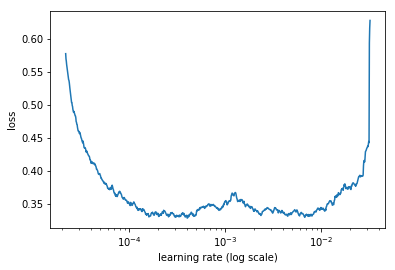

In [107]:
m.sched.plot(100)

In [108]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-4/1.1

In [109]:
m.fit(lr, 3, metrics=[rmsle])

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   rmsle                         
    0      0.318883   0.343378   0.210507  
    1      0.30198    0.324165   0.208273                      
    2      0.307295   0.338393   0.209531                      



[0.3383929, 0.2095314960915929]

In [116]:
lr = 1e-4
m.fit(lr, 20, metrics=[rmsle], cycle_len=3, cycle_mult=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=60), HTML(value='')))

epoch      trn_loss   val_loss   rmsle                         
    0      0.292008   0.340122   0.210913  
    1      0.280181   0.348281   0.211798                      
    2      0.287628   0.35659    0.21342                       
    3      0.290715   0.348601   0.213467                      
    4      0.275758   0.355558   0.213066                      
    5      0.279356   0.359688   0.214379                      
    6      0.289535   0.368537   0.216161                      
    7      0.283198   0.360726   0.214673                      
    8      0.274161   0.363977   0.215295                      
    9      0.282894   0.360507   0.215914                      
 13%|█▎        | 225/1759 [00:04<00:31, 48.22it/s, loss=0.273]

KeyboardInterrupt: 

 13%|█▎        | 225/1759 [00:20<02:16, 11.24it/s, loss=0.273]

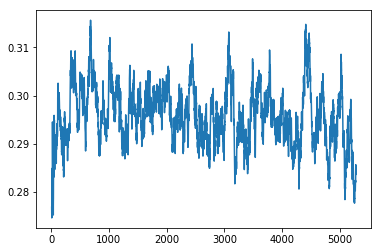

In [114]:
m.sched.plot_loss()

In [115]:
x,y=m.predict_with_targs()
rmsle(x,y)

0.21373713471361197

In [28]:
contin_vars


['prop_yhat_lower',
 'prop_yhat_upper',
 'prop_yhat',
 'stores_in_air_loc',
 'stores_in_hpg_loc',
 'stores_in_area_name',
 'stores_in_hpg_area_name',
 'min_visits_in_air_store_id',
 'max_visits_in_air_store_id',
 'mean_visits_in_air_store_id',
 'std_visits_in_air_store_id',
 'min_visits_in_air_loc',
 'max_visits_in_air_loc',
 'mean_visits_in_air_loc',
 'std_visits_in_air_loc',
 'min_visits_in_hpg_loc',
 'max_visits_in_hpg_loc',
 'mean_visits_in_hpg_loc',
 'std_visits_in_hpg_loc',
 'min_visits_in_area_name',
 'max_visits_in_area_name',
 'mean_visits_in_area_name',
 'std_visits_in_area_name',
 'min_visits_in_hpg_area_name',
 'max_visits_in_hpg_area_name',
 'mean_visits_in_hpg_area_name',
 'std_visits_in_hpg_area_name']

In [34]:
cat_sz


[('air_store_id', 822),
 ('visit_Year', 3),
 ('visit_Month', 13),
 ('visit_Week', 54),
 ('visit_Day', 32),
 ('visit_Dayofweek', 8),
 ('visit_Dayofyear', 367),
 ('visit_Is_month_end', 3),
 ('visit_Is_month_start', 3),
 ('visit_Is_quarter_end', 3),
 ('visit_Is_quarter_start', 3),
 ('visit_Is_year_end', 3),
 ('visit_Is_year_start', 3),
 ('visit_Elapsed', 477),
 ('day_of_week', 8),
 ('holiday_flg', 3),
 ('af_holiday_flg', 75),
 ('be_holiday_flg', 75),
 ('dur_time_holiday_flg', 8),
 ('dur_holiday_flg', 6),
 ('dur_prog_holiday_flg', 8),
 ('genre_name', 15),
 ('area_name', 72),
 ('hpb_genre_name', 16),
 ('hpb_area_name', 33),
 ('air_loc', 74),
 ('hpb_loc', 34)]

In [387]:
csv_fn=f'sub1.csv'
pred_test=m.predict(True)
pred_test = np.exp(pred_test)
test_set['visitors']=pred_test
sub = utils.trn2test(test_set.reset_index()[['air_store_id', 'visit_date', 'visitors']])
sub.to_csv(csv_fn, index=False)

In [388]:
FileLink(csv_fn)


/notebooks/sub1.csv

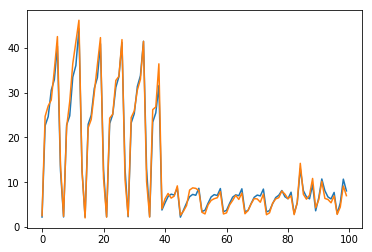

In [326]:
plt.plot(test_set.prop_yhat.values[:100])
plt.plot(pred_test[:100])